In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(31, 51245)

In [4]:
data_loaded['Sum PrestoKNe_score_s UserPointsSlicer'].loc['ender_a1_v3.1_10yrs'], data_loaded['Sum PrestoKNe_score_s UserPointsSlicer'].loc['baseline_v3.0_10yrs']

(204.0, 200.0)

In [5]:
#[col for col in data_loaded.columns if 'LVDwarfs' in col]
#[col for col in data_loaded.columns if 'KNePop' in col and 'Total detected' in col and 'ztfrest_simple ' in col and 'DD' in col ]
[col for col in data_loaded.columns if 'Presto' in col]

['Median PrestoKNe_presto_color_detect UserPointsSlicer',
 'Median PrestoKNe_score_p UserPointsSlicer',
 'Median PrestoKNe_score_s UserPointsSlicer',
 'Sum PrestoKNe_presto_color_detect UserPointsSlicer',
 'Sum PrestoKNe_score_p UserPointsSlicer',
 'Sum PrestoKNe_score_s UserPointsSlicer']

In [6]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'FF u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'FF g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'FF r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'FF i',
    'best18k parallax HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
             'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
             'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            #}
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'FF u': '',
         'FF g': '',
         'FF r': '',
         'FF i': '',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 

In [7]:
#data['KNe single model'] # data['KNe ZTF simple']

In [8]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [9]:
mag_data

,g,i,r,u,y,z
baseline_v2.0_10yrs,26.733479,26.218659,26.755971,25.818916,24.762720,25.510379
baseline_v2.1_10yrs,26.736248,26.252054,26.781543,25.751969,24.728145,25.486640
baseline_v2.2_10yrs,26.753646,26.290929,26.835430,25.724699,24.782743,25.581317
baseline_v3.0_10yrs,26.688123,26.264600,26.818287,25.668262,24.756955,25.524781
baseline_v3.2_10yrs,26.696522,26.280475,26.811614,25.622221,24.780784,25.566586
ender_a1_v3.1_10yrs,26.696522,26.280475,26.811614,25.622221,24.780784,25.566586
near_sun_fdw_0.00_v3.2_10yrs,26.690302,26.278797,26.811682,25.621410,24.771032,25.569362
near_sun_fdw_0.01_v3.2_10yrs,26.686461,26.285171,26.814156,25.612116,24.772132,25.569879
near_sun_fdw_0.03_v3.2_10yrs,26.687070,26.285774,26.815221,25.612561,24.772677,25.570069
near_sun_fdw_0.30_v3.2_10yrs,26.686835,26.280805,26.815924,25.621254,24.768237,25.571061


In [10]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS,Kne COSMOS,Kne ECDFS,Kne EDFS,Kne ELAISS1,Kne WFD,Kne XMM_LSS
baseline_v2.0_10yrs,47.333916,5.217382,NaN,81.438800,72.445437,0.596891,0.543027,NaN,0.593426,0.562289,398.0,401.0,470.0,427.0,337.0,415.0
baseline_v2.1_10yrs,21.899369,2.592571,NaN,40.212476,32.838014,0.594427,0.545216,NaN,0.594464,0.561932,382.0,413.0,444.0,392.0,302.0,404.0
baseline_v2.2_10yrs,13.647867,6.881372,NaN,3.753806,NaN,0.514987,0.577431,NaN,0.600156,NaN,398.0,435.0,530.0,418.0,339.0,403.0
baseline_v3.0_10yrs,362.726856,72.383449,74.734786,37.378088,60.363667,0.594675,0.575080,0.526724,0.546128,0.539335,476.0,442.0,539.0,433.0,365.0,363.0
baseline_v3.2_10yrs,567.853209,331.480163,698.794240,297.421154,311.588766,0.566437,0.588491,0.527025,0.577627,0.557767,368.0,361.0,426.0,357.0,293.0,321.0
ender_a1_v3.1_10yrs,567.853209,331.480163,698.794240,297.421154,311.588766,0.566437,0.588491,0.527025,0.577627,0.557767,368.0,361.0,426.0,357.0,293.0,321.0
near_sun_fdw_0.00_v3.2_10yrs,567.231261,327.777234,688.274109,295.505496,313.742457,0.570098,0.587360,0.523428,0.578706,0.562208,377.0,340.0,422.0,334.0,297.0,331.0
near_sun_fdw_0.01_v3.2_10yrs,565.748210,329.572450,690.322581,297.939660,313.618530,0.568912,0.588329,0.523566,0.577415,0.558258,371.0,364.0,453.0,330.0,287.0,330.0
near_sun_fdw_0.03_v3.2_10yrs,565.748210,329.572450,690.322581,297.939660,313.618530,0.568912,0.588329,0.523566,0.577415,0.558258,371.0,364.0,453.0,330.0,287.0,330.0
near_sun_fdw_0.30_v3.2_10yrs,565.207215,329.361972,691.946649,297.888320,311.979173,0.566674,0.587787,0.524207,0.577395,0.562092,387.0,391.0,432.0,353.0,301.0,316.0


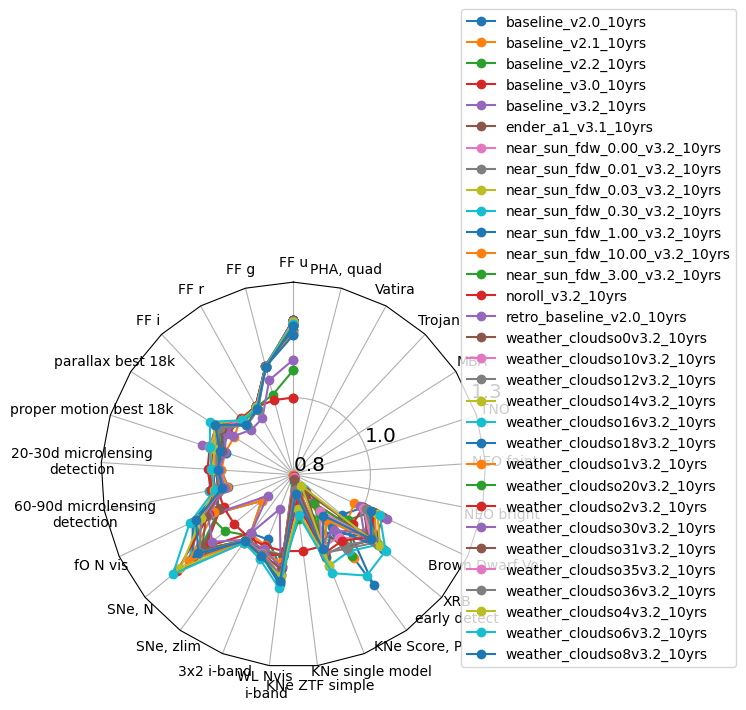

In [11]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.3], bbox_to_anchor=(1.65, 0))

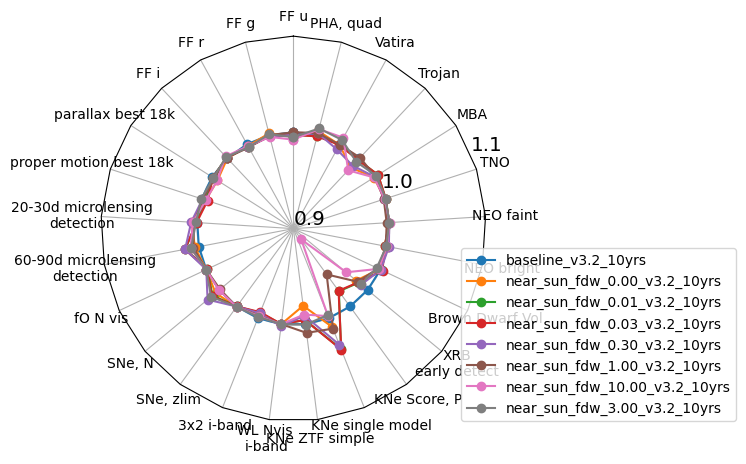

In [13]:
# Desi north
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'near_sun' in run] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [16]:
data['Vatira']

baseline_v2.0_10yrs                 NaN
baseline_v2.1_10yrs                 NaN
baseline_v2.2_10yrs                 NaN
baseline_v3.0_10yrs                 NaN
baseline_v3.2_10yrs              0.4445
ender_a1_v3.1_10yrs              0.4445
near_sun_fdw_0.00_v3.2_10yrs     0.4439
near_sun_fdw_0.01_v3.2_10yrs     0.4441
near_sun_fdw_0.03_v3.2_10yrs     0.4438
near_sun_fdw_0.30_v3.2_10yrs     0.4384
near_sun_fdw_1.00_v3.2_10yrs     0.4440
near_sun_fdw_10.00_v3.2_10yrs    0.4523
near_sun_fdw_3.00_v3.2_10yrs     0.4496
noroll_v3.2_10yrs                0.4478
retro_baseline_v2.0_10yrs           NaN
weather_cloudso0v3.2_10yrs       0.4445
weather_cloudso10v3.2_10yrs      0.4411
weather_cloudso12v3.2_10yrs      0.4346
weather_cloudso14v3.2_10yrs      0.4427
weather_cloudso16v3.2_10yrs      0.4406
weather_cloudso18v3.2_10yrs      0.4406
weather_cloudso1v3.2_10yrs       0.4477
weather_cloudso20v3.2_10yrs      0.4375
weather_cloudso2v3.2_10yrs       0.4455
weather_cloudso30v3.2_10yrs      0.4307


In [14]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs', 'ender_a1_v3.1_10yrs', 'baseline_v3.2_10yrs']

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_data



,FF u,FF g,FF r,FF i,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N",...,"KNe Score, P",XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"PHA, quad"
retro_baseline_v2.0_10yrs,0.893276,0.949104,0.960964,0.958616,0.804328,0.176701,0.0883,0.1533,848.0,97124.012102,...,202.730488,720.0,179640.718155,NaN,NaN,NaN,NaN,NaN,NaN,NaN
baseline_v2.0_10yrs,0.955776,0.981594,0.994441,0.997035,0.791058,0.184088,0.3116,0.4284,839.0,99302.532220,...,263.696398,1879.0,168086.074111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
baseline_v2.1_10yrs,0.948661,0.984188,0.996912,0.999012,0.806910,0.188258,0.3111,0.4312,838.0,99294.339899,...,243.713720,1918.0,163815.013503,NaN,NaN,NaN,NaN,NaN,NaN,NaN
baseline_v2.2_10yrs,0.871233,0.914268,0.993947,0.998023,0.792958,0.186345,0.3212,0.4462,830.0,112802.099640,...,242.377184,1920.0,172453.127988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
baseline_v3.0_10yrs,0.813058,0.901174,0.993823,0.999135,0.792666,0.185683,0.3239,0.4559,795.0,109475.798536,...,228.428876,1950.0,168032.537231,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ender_a1_v3.1_10yrs,0.977539,0.981717,0.997035,0.995676,0.782077,0.185427,0.3341,0.4634,805.0,121007.562022,...,235.320866,2080.0,173433.444317,0.9392,0.642068,0.720883,0.925484,0.598403,0.4445,0.869906
baseline_v3.2_10yrs,0.977539,0.981717,0.997035,0.995676,0.782077,0.185427,0.3341,0.4634,805.0,121007.562022,...,235.320866,2080.0,173433.444317,0.9392,0.642068,0.720883,0.925484,0.598403,0.4445,0.869906


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_55656/2399318704.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


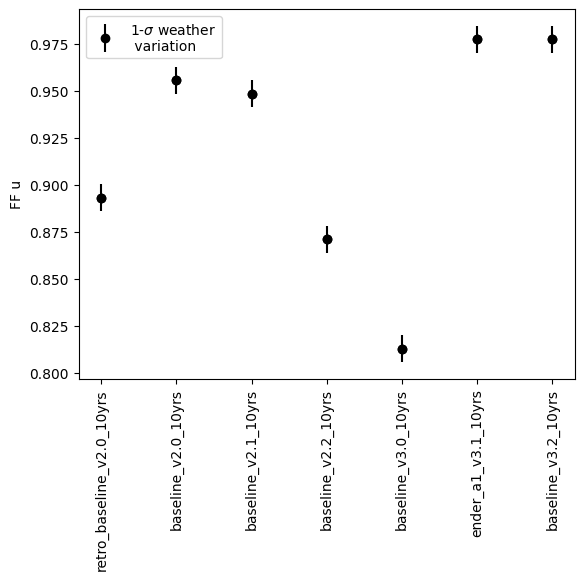

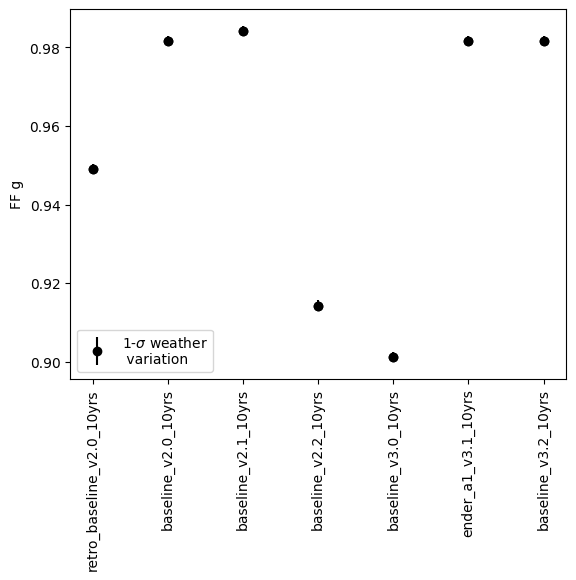

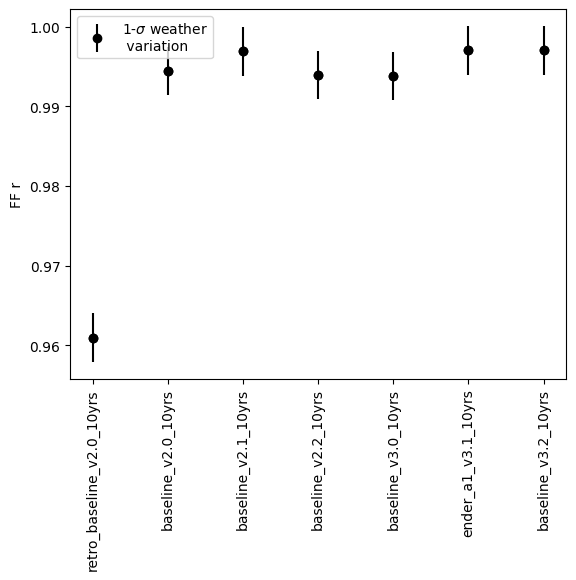

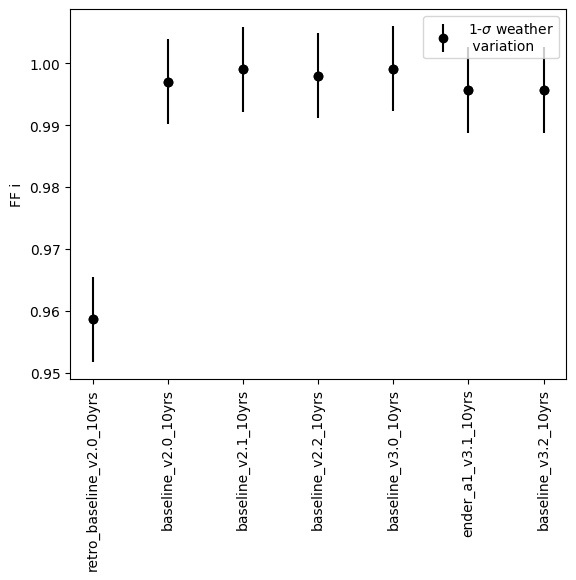

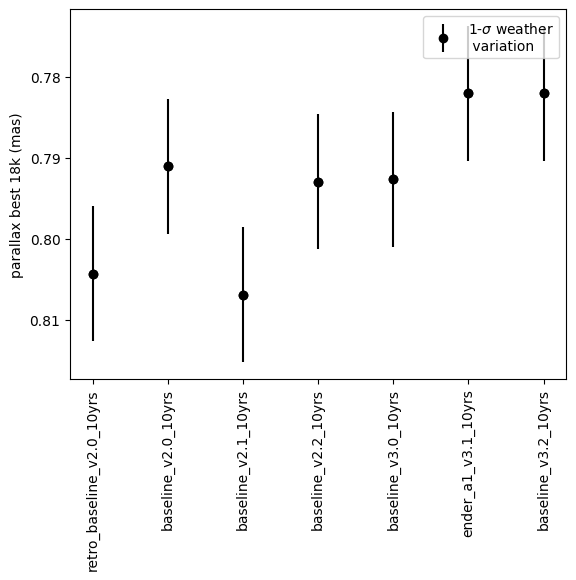

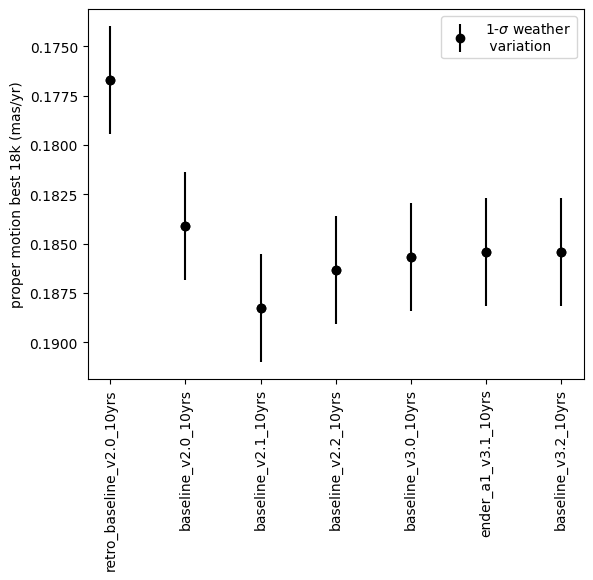

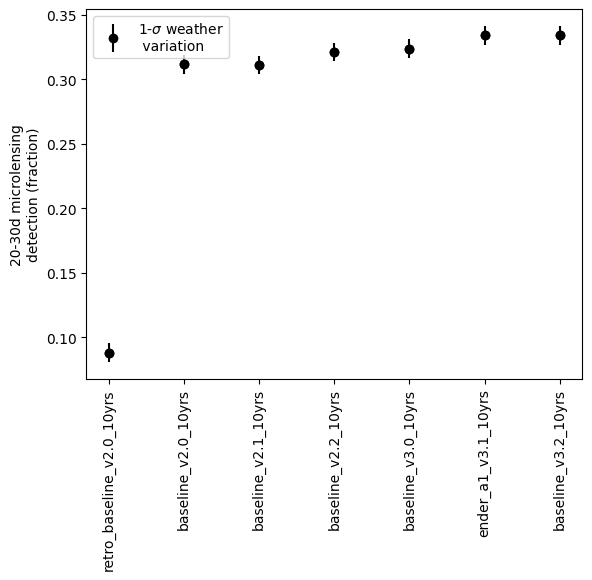

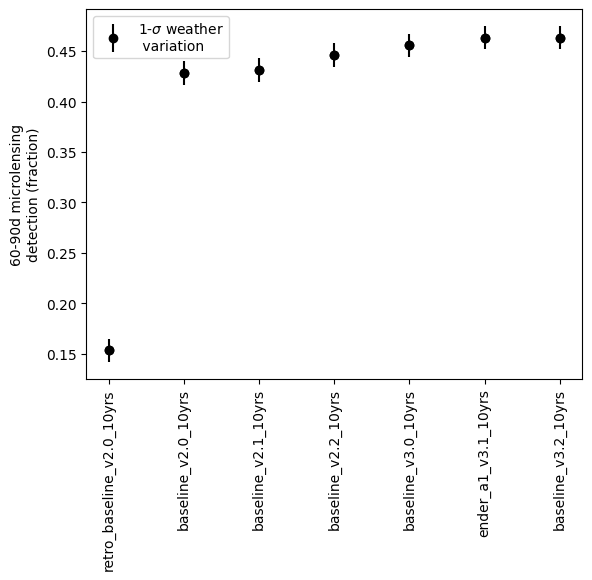

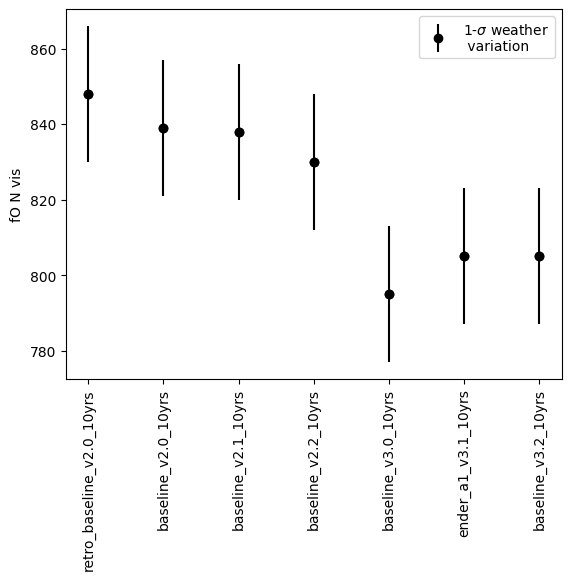

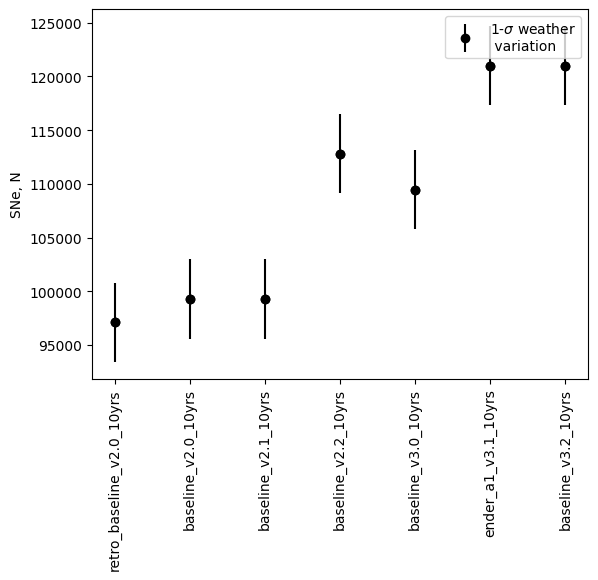

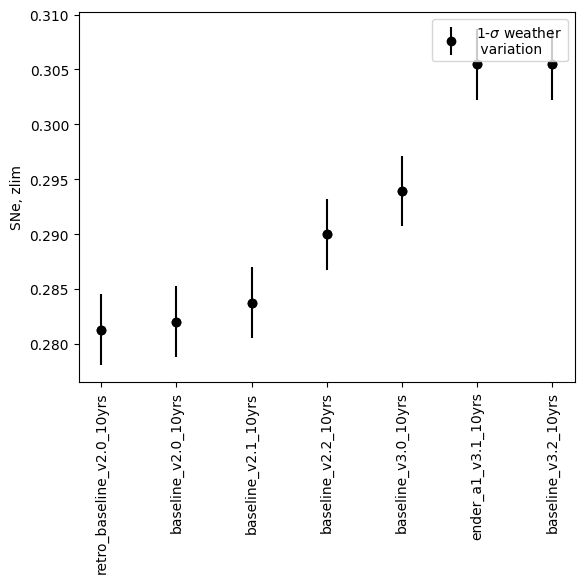

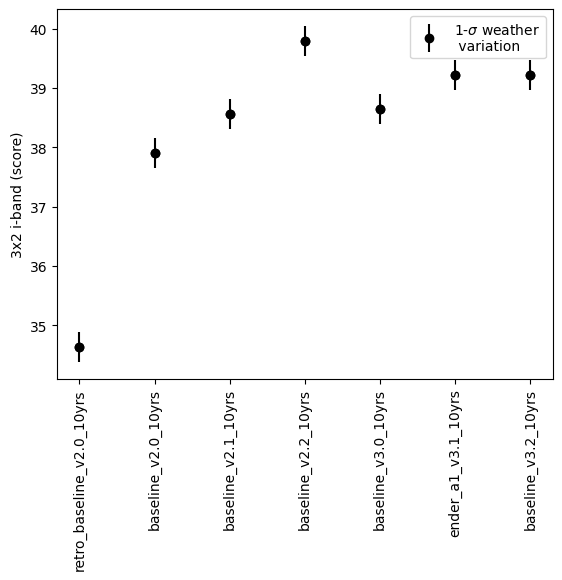

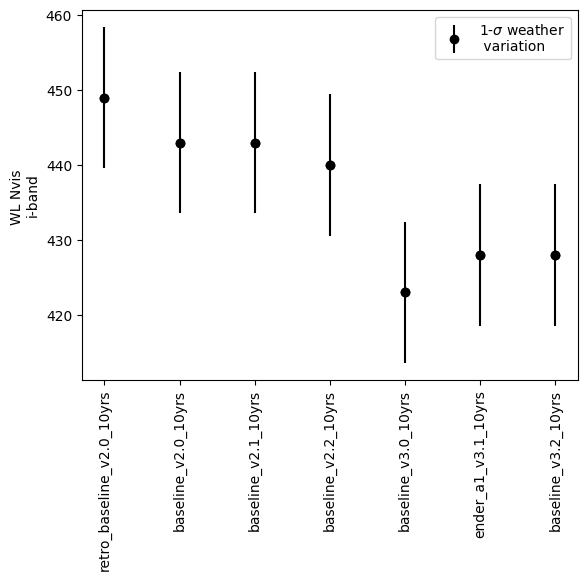

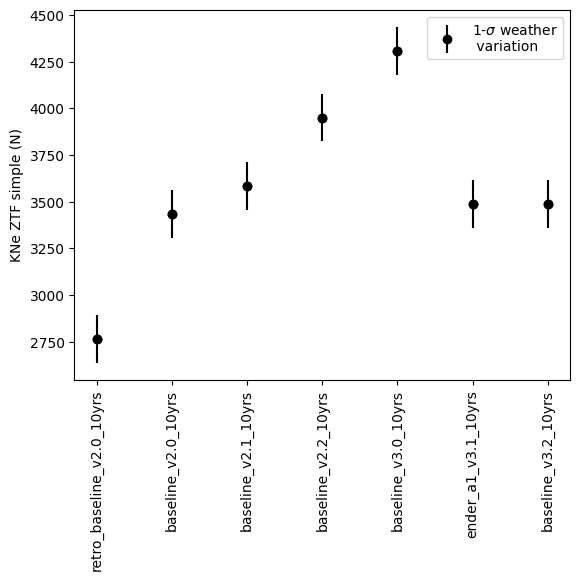

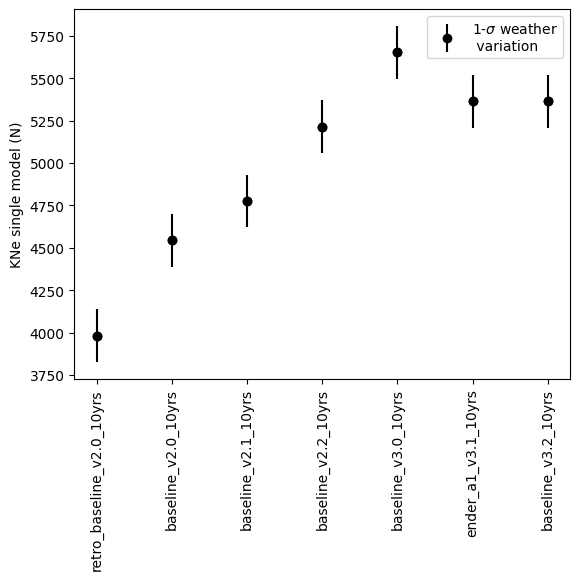

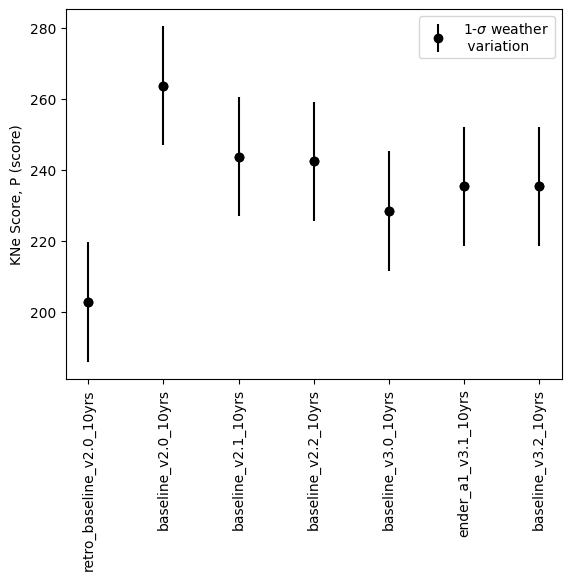

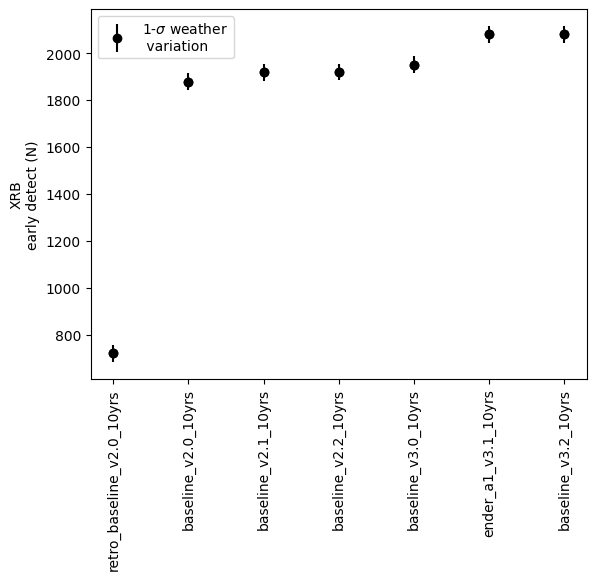

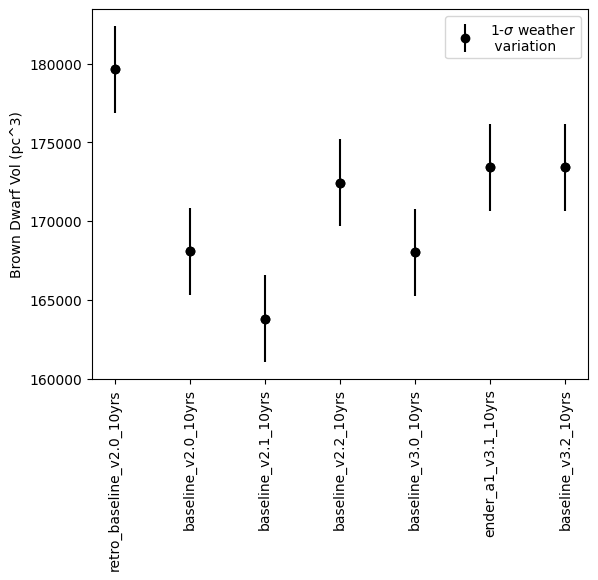

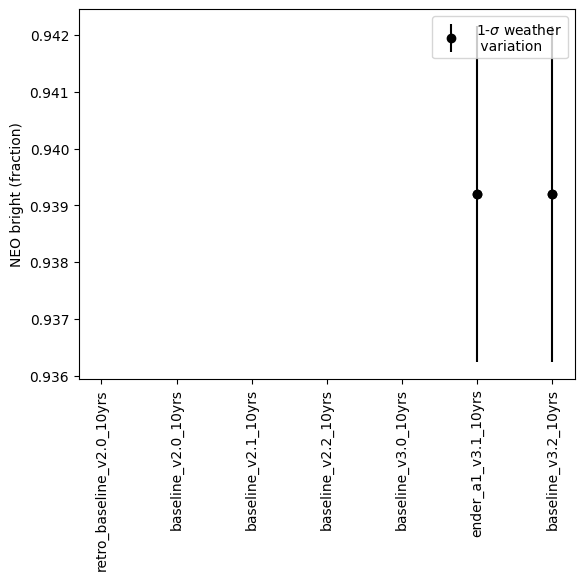

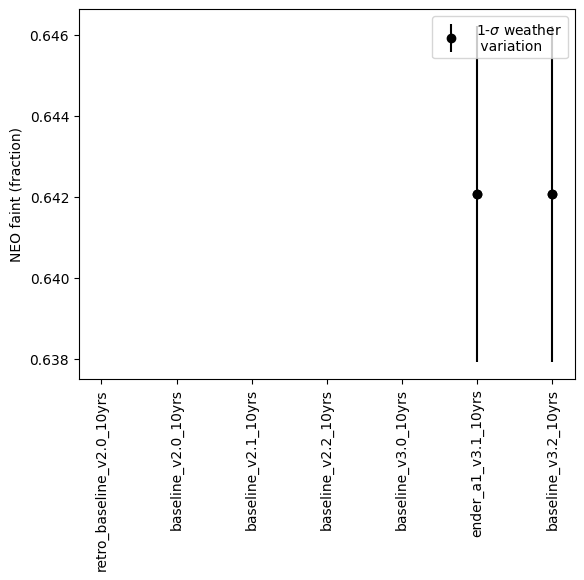

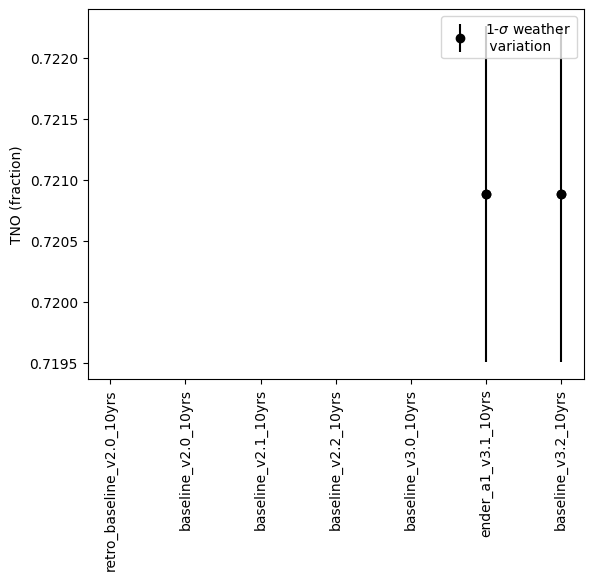

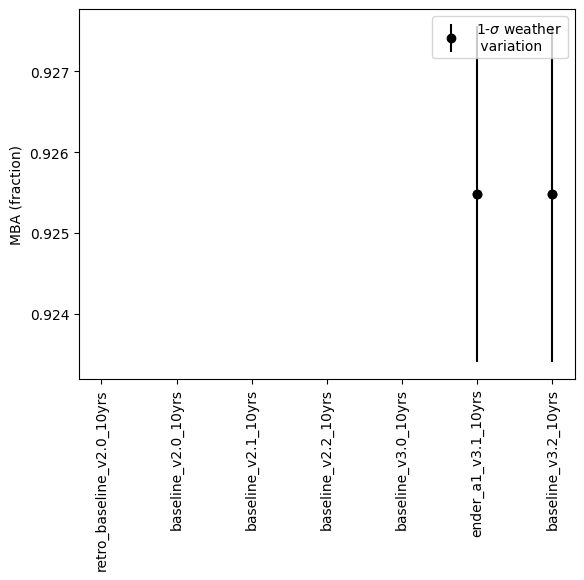

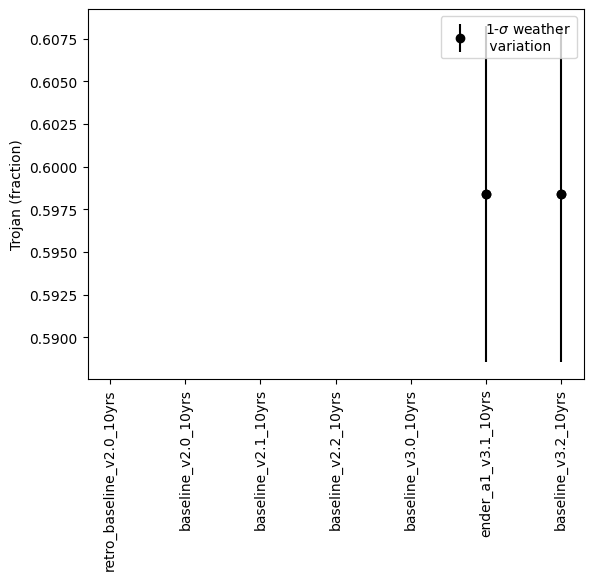

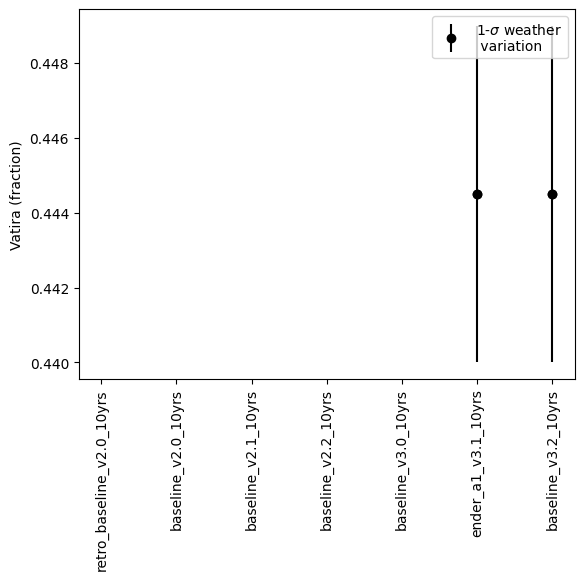

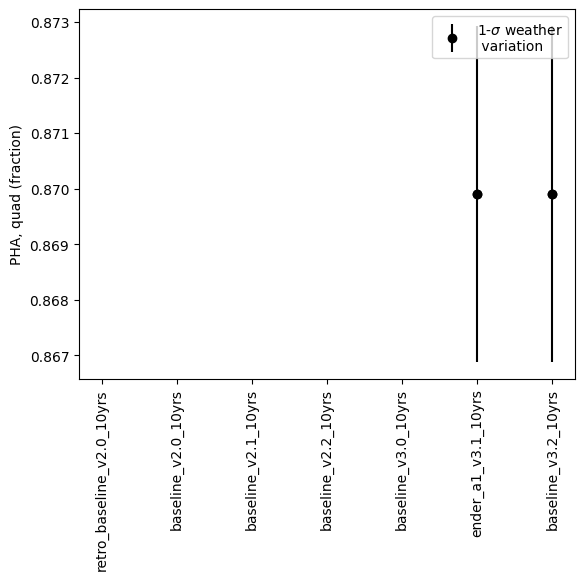

In [15]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


In [20]:
[col for col in data_loaded.columns if 'twilight' in col]

['Identity Counts_twilight_near_sun, 0 UniSlicer',
 'Identity Counts_twilight_near_sun, 1 UniSlicer',
 'Identity Counts_twilight_near_sun, 2 UniSlicer',
 'Identity Counts_twilight_near_sun, 3 UniSlicer',
 'Identity Counts_twilight_neo UniSlicer',
 'Identity Counts_twilight_neo, 0 UniSlicer',
 'Identity Counts_twilight_neo, 1 UniSlicer',
 'Identity Counts_twilight_neo, 2 UniSlicer',
 'Identity Counts_twilight_neo, 3 UniSlicer',
 'Identity Percents_twilight_near_sun, 0 UniSlicer',
 'Identity Percents_twilight_near_sun, 1 UniSlicer',
 'Identity Percents_twilight_near_sun, 2 UniSlicer',
 'Identity Percents_twilight_near_sun, 3 UniSlicer',
 'Identity Percents_twilight_neo UniSlicer',
 'Identity Percents_twilight_neo, 0 UniSlicer',
 'Identity Percents_twilight_neo, 1 UniSlicer',
 'Identity Percents_twilight_neo, 2 UniSlicer',
 'Identity Percents_twilight_neo, 3 UniSlicer']

In [21]:
data_loaded['Identity Counts_twilight_near_sun, 2 UniSlicer']

baseline_v2.0_10yrs                  NaN
baseline_v2.1_10yrs                  NaN
baseline_v2.2_10yrs                  NaN
baseline_v3.0_10yrs                  NaN
baseline_v3.2_10yrs              12221.0
ender_a1_v3.1_10yrs                  NaN
near_sun_fdw_0.00_v3.2_10yrs     12260.0
near_sun_fdw_0.01_v3.2_10yrs     12146.0
near_sun_fdw_0.03_v3.2_10yrs     12157.0
near_sun_fdw_0.30_v3.2_10yrs     12233.0
near_sun_fdw_1.00_v3.2_10yrs     12296.0
near_sun_fdw_10.00_v3.2_10yrs    12387.0
near_sun_fdw_3.00_v3.2_10yrs     12488.0
noroll_v3.2_10yrs                12154.0
retro_baseline_v2.0_10yrs            NaN
weather_cloudso0v3.2_10yrs       12221.0
weather_cloudso10v3.2_10yrs      12223.0
weather_cloudso12v3.2_10yrs      11767.0
weather_cloudso14v3.2_10yrs      12119.0
weather_cloudso16v3.2_10yrs      12133.0
weather_cloudso18v3.2_10yrs      11837.0
weather_cloudso1v3.2_10yrs       12142.0
weather_cloudso20v3.2_10yrs      12184.0
weather_cloudso2v3.2_10yrs       12336.0
weather_cloudso3